In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.cm as cm

In [3]:
assessor_dir = 'datasets/assessorSequential.csv' 
df = pd.read_csv(assessor_dir)
# assessor_df = assessor_df_cleaned(assessor_df)

In [4]:
df.drop(columns=['Unnamed: 0', 'PIN','Township Code','Neighborhood Code','Sale Price','Age','ZIP','Longitude','Latitude'], inplace=True)

In [5]:
df[~df.isin(['NaN','NaT']).any(axis=1)]
df.shape
df.dropna(inplace=True)
df.shape

(992, 14)

In [6]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [7]:
draw_cols = df.columns[2:13]
draw_cols

Index(['X1st.Draw', 'X2nd.Draw', 'X3rd.Draw', 'X4th.Draw', 'X5th.Draw',
       'X6th.Draw', 'X7th.Draw', 'X8th.Draw', 'X9th.Draw', 'X10th.Draw',
       'X11th.Draw'],
      dtype='object')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

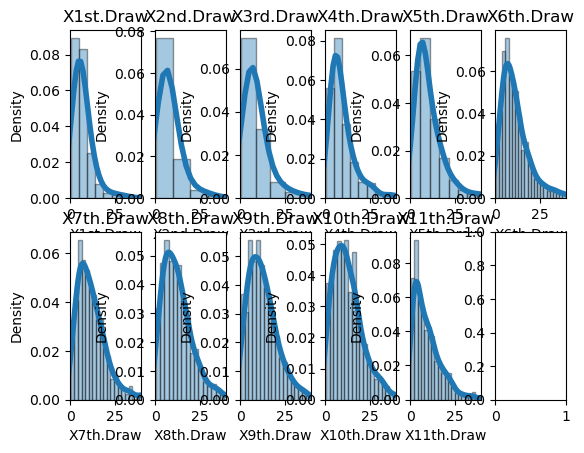

In [8]:
fig,axs = plt.subplots(2,6)
plt.rcParams['figure.figsize'] = 10, 8
# plt.rcParams['font.size'] = 5

for i, ax in zip(range(len(draw_cols)), axs.flatten()):
    sns.distplot(df[draw_cols[i]], ax=ax, hist=True, kde=True,  
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    ax.set_xlim(0, 40)
    ax.set_title(draw_cols[i])

plt.show()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics

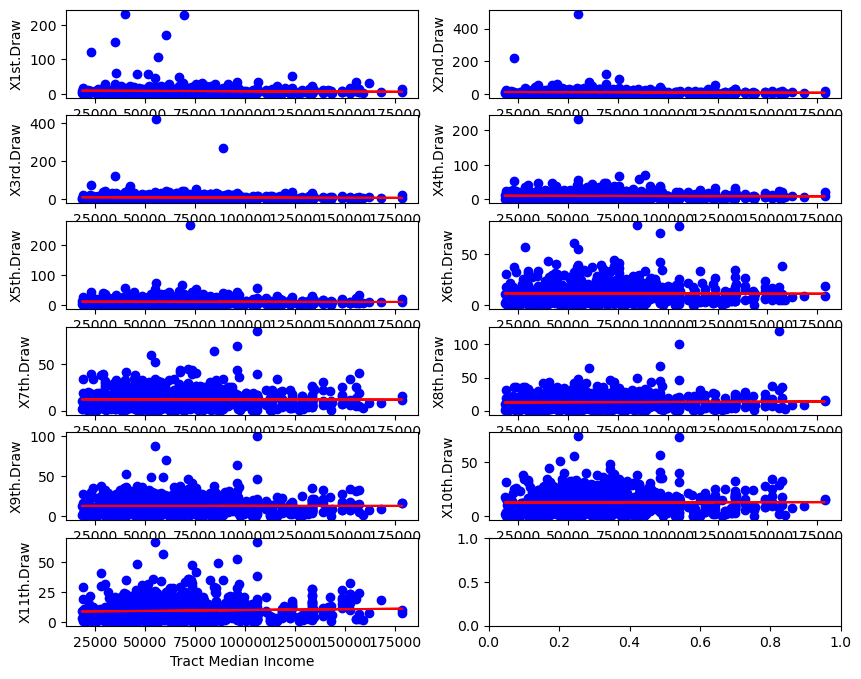

In [10]:
fig,axs = plt.subplots(6,2)
plt.rcParams['figure.figsize'] = 10, 8

for i, ax in zip(range(len(draw_cols)), axs.flatten()):
    x = df['Tract Median Income'].values.reshape(-1,1)
    y = df[draw_cols[i]].values.reshape(-1,1)
    regressor = LinearRegression()
    regressor.fit(x, y)
    y_pred = regressor.predict(x)

    ax.scatter(x, y, color='blue', marker='o')
    ax.plot(x, y_pred, color='red')
    # ax.set_title(draw_cols[i])
    ax.set_xlabel('Tract Median Income')
    ax.set_ylabel(draw_cols[i])
 
plt.show() 
# plt.xlabel('Tract Median Income')
# plt.ylabel('6th draw')
 
# plt.scatter(x=df['Tract Median Income'], y=df['X6th.Draw'], marker='o')
# plt.show()

In [11]:
from patsy import dmatrices

In [12]:
for i in range(len(draw_cols)):
    df['draw_{}'.format(i+1)] = df[draw_cols[i]]

df.drop(columns=draw_cols, inplace=True)

In [13]:
df

,Date.Sampled,Address,Tract Median Income,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,draw_10,draw_11
0,9/4/2019,100XX S BELL AVE,122727.0,1.52,1.37,1.59,2.53,2.44,1.90,2.45,2.92,3.75,3.86,4.35
1,7/16/2016,100XX S CALHOUN AVE,44423.0,3.70,2.62,8.83,13.80,13.20,13.60,12.30,11.80,10.80,8.01,2.75
2,12/17/2019,100XX S CALUMET AVE,40612.0,4.02,5.35,6.97,6.55,17.70,16.60,12.10,11.60,12.00,11.10,8.72
3,12/14/2019,100XX S CARPENTER ST,37207.0,9.54,7.31,6.95,5.63,4.91,7.15,12.40,13.10,10.10,9.54,7.23
5,12/14/2021,100XX S LASALLE ST,39787.0,10.00,8.80,6.90,6.20,8.30,9.90,11.00,9.80,10.00,9.50,5.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800,9/21/2021,9XX N FAIRFIELD AVE,57362.0,6.61,8.73,10.20,13.90,20.50,21.90,17.80,12.40,18.10,22.20,13.20
1802,1/26/2022,9XX W GUNNISON ST,41445.0,6.20,7.00,7.20,8.90,9.80,9.70,9.40,9.40,12.00,22.00,18.00
1804,11/22/2021,XX W 78TH ST,34657.0,11.00,11.40,8.06,8.49,21.40,28.60,29.30,19.70,18.10,17.20,7.06
1805,10/28/2021,XX W 81ST ST,39097.0,4.41,5.43,4.96,3.87,4.80,4.93,9.11,8.83,10.40,12.20,2.37


In [14]:
df['tract_income'] = df['Tract Median Income']
df.drop(columns=['Tract Median Income'], inplace=True)

In [15]:
draw_cols1 = df.columns[2:13]
draw_cols1

Index(['draw_1', 'draw_2', 'draw_3', 'draw_4', 'draw_5', 'draw_6', 'draw_7',
       'draw_8', 'draw_9', 'draw_10', 'draw_11'],
      dtype='object')

In [16]:
df['median_lead'] = df[draw_cols1].median(axis=1)
df = df.drop(columns=draw_cols1)
df

,Date.Sampled,Address,tract_income,median_lead
0,9/4/2019,100XX S BELL AVE,122727.0,2.45
1,7/16/2016,100XX S CALHOUN AVE,44423.0,10.80
2,12/17/2019,100XX S CALUMET AVE,40612.0,11.10
3,12/14/2019,100XX S CARPENTER ST,37207.0,7.31
5,12/14/2021,100XX S LASALLE ST,39787.0,9.50
...,...,...,...,...
1800,9/21/2021,9XX N FAIRFIELD AVE,57362.0,13.90
1802,1/26/2022,9XX W GUNNISON ST,41445.0,9.40
1804,11/22/2021,XX W 78TH ST,34657.0,17.20
1805,10/28/2021,XX W 81ST ST,39097.0,4.96


In [17]:
df_val = df[['tract_income','median_lead']]


In [18]:
# find number of points 
nQuantiles = len(df.index)

# take only the two columns you want 
# df_ = df[['Tract Median Income', 'avg']]
# sort by increasing income 
df.sort_values(by=['tract_income'], inplace=True)

# calculate quantiles 
quantiles = np.linspace(float(1/(2*nQuantiles)), 1-float(1/(2*nQuantiles)), nQuantiles)
# add quantiles to dataframe 
df['quantile'] = quantiles

In [19]:
nQuantiles

992

In [20]:
df.head(100)

,Date.Sampled,Address,tract_income,median_lead,quantile
1485,2/4/2020,72XX S EUCLID AVE,18432.0,10.10,0.000504
1484,1/15/2020,72XX S CORNELL AVE,18432.0,1.79,0.001512
1381,3/28/2022,64XX S LANGLEY AVE,18983.0,0.50,0.002520
835,12/6/2019,42XX S PRAIRIE AVE,19015.0,15.70,0.003528
834,9/13/2019,42XX S PRAIRIE AVE,19015.0,25.90,0.004536
...,...,...,...,...,...
1503,12/1/2021,73XX S INDIANA AVE,36806.0,4.78,0.096270
1236,9/3/2016,59XX S ADA ST,36875.0,14.80,0.097278
91,3/4/2022,111XX S LOOMIS ST,37159.0,4.60,0.098286
148,3/3/2020,11XX W 111TH ST,37159.0,1.90,0.099294


In [21]:
df[df['quantile'] == max(df['quantile'])]


,Date.Sampled,Address,tract_income,median_lead,quantile
343,8/27/2016,18XX W WELLINGTON AVE,178750.0,9.32,0.999496


In [22]:
df[df['quantile'] == min(df['quantile'])]

,Date.Sampled,Address,tract_income,median_lead,quantile
1485,2/4/2020,72XX S EUCLID AVE,18432.0,10.1,0.000504


In [23]:
df[df['quantile'] <= df['quantile'].quantile(0.5)]

,Date.Sampled,Address,tract_income,median_lead,quantile
1485,2/4/2020,72XX S EUCLID AVE,18432.0,10.10,0.000504
1484,1/15/2020,72XX S CORNELL AVE,18432.0,1.79,0.001512
1381,3/28/2022,64XX S LANGLEY AVE,18983.0,0.50,0.002520
835,12/6/2019,42XX S PRAIRIE AVE,19015.0,15.70,0.003528
834,9/13/2019,42XX S PRAIRIE AVE,19015.0,25.90,0.004536
...,...,...,...,...,...
1565,1/30/2020,79XX S MAPLEWOOD AVE,66886.0,23.20,0.495464
1577,9/21/2021,80XX S ALBANY AVE,66886.0,6.80,0.496472
1612,9/9/2019,82XX S TROY ST,66886.0,4.11,0.497480
1566,3/31/2022,79XX S RICHMOND ST,66886.0,6.90,0.498488


In [24]:
df[df['quantile'] >= df['quantile'].quantile(0.5)]


,Date.Sampled,Address,tract_income,median_lead,quantile
1189,2/1/2022,57XX W WAVELAND AVE,67500.0,8.80,0.500504
1243,11/7/2018,59XX W BYRON ST,67500.0,15.40,0.501512
1242,10/21/2021,59XX W BYRON ST,67500.0,18.60,0.502520
1214,8/13/2019,58XX W PATTERSON AVE,67500.0,16.60,0.503528
1248,10/4/2019,59XX W WARWICK AVE,67500.0,13.00,0.504536
...,...,...,...,...,...
394,10/17/2018,20XX W WILLOW ST,159020.0,3.10,0.995464
258,10/13/2016,16XX N CLEVELAND AVE,162054.0,8.41,0.996472
232,5/24/2018,14XX W GEORGE ST,168352.0,8.56,0.997480
365,8/9/2018,19XX W NELSON ST,178750.0,16.00,0.998488


In [25]:
q_01 = df[df['quantile'] <= df['quantile'].quantile(0.1)]
q_005 = df[df['quantile'] <= df['quantile'].quantile(0.05)]

In [26]:
q_025 = df[df['quantile'] <= df['quantile'].quantile(0.25)]
q_025['median_lead'].median()

8.495000000000001

In [27]:
q_075 = df[df['quantile'] >= df['quantile'].quantile(0.75)]
q_075['median_lead'].median()

8.565000000000001

In [28]:
q_9 = df[df['quantile'] >= df['quantile'].quantile(0.9)]
q_9['median_lead'].median()

8.21

In [29]:
q_25_75 = df[(df['quantile'] < df['quantile'].quantile(0.75)) &  (df['quantile'] > df['quantile'].quantile(0.25))]
q_25_75['median_lead'].median()

8.364999999999998

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

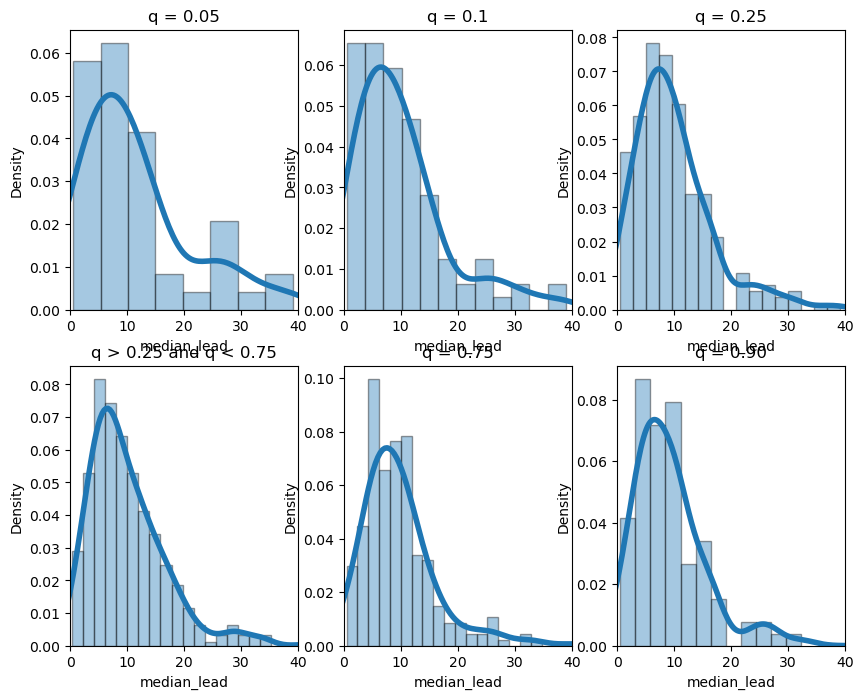

In [40]:
lst_q = [q_005,q_01, q_025,q_25_75, q_075, q_9]
q_names = ['q = 0.05','q = 0.1', 'q = 0.25','q > 0.25 and q < 0.75', 'q = 0.75', 'q = 0.90']
fig,axs = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = 10, 8
# plt.rcParams['font.size'] = 5

for i, ax in zip(range(len(lst_q)), axs.flatten()):
    sns.distplot(lst_q[i]['median_lead'], ax=ax, hist=True, kde=True,  
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    ax.set_xlim(0, 40)
    ax.set_title(q_names[i])

plt.show()

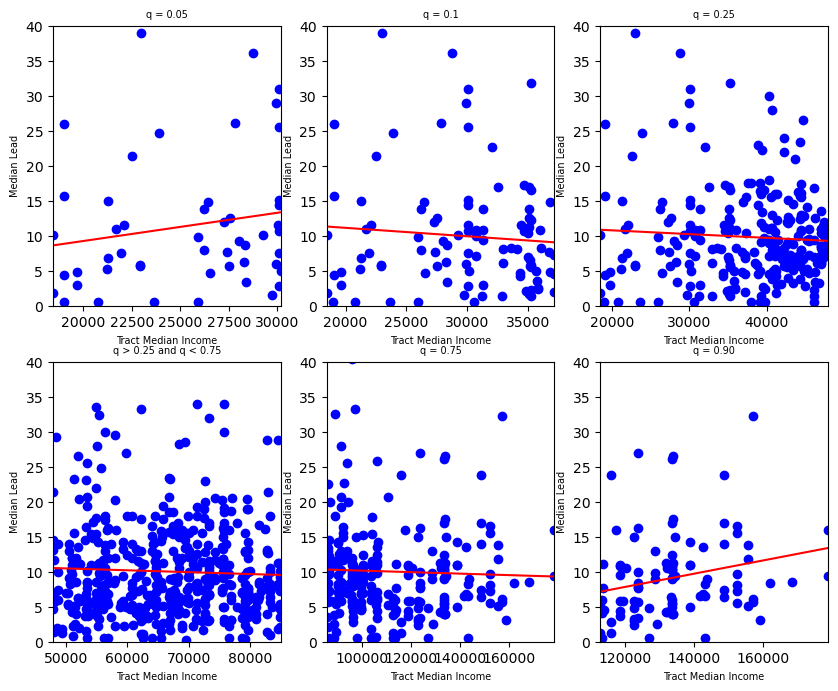

In [55]:
fig,axs = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = 10, 8






for i, ax in zip(range(len(lst_q)), axs.flatten()):
    x = lst_q[i]['tract_income'].values.reshape(-1,1)
    y = lst_q[i]['median_lead'].values.reshape(-1,1)
    regressor = LinearRegression()
    regressor.fit(x, y)
    y_pred = regressor.predict(x)

    ax.scatter(x, y, color='blue', marker='o')
    ax.plot(x, y_pred, color='red')
    ax.set_title(q_names[i], fontsize=7)
    ax.set_xlabel('Tract Median Income', fontsize=7)
    ax.set_ylabel('Median Lead', fontsize=7)
    #set appropriate x and y limits
    ax.set_xlim(min(lst_q[i]['tract_income']), max(lst_q[i]['tract_income']))
    ax.set_ylim(0, 40)
    
 
plt.show() 

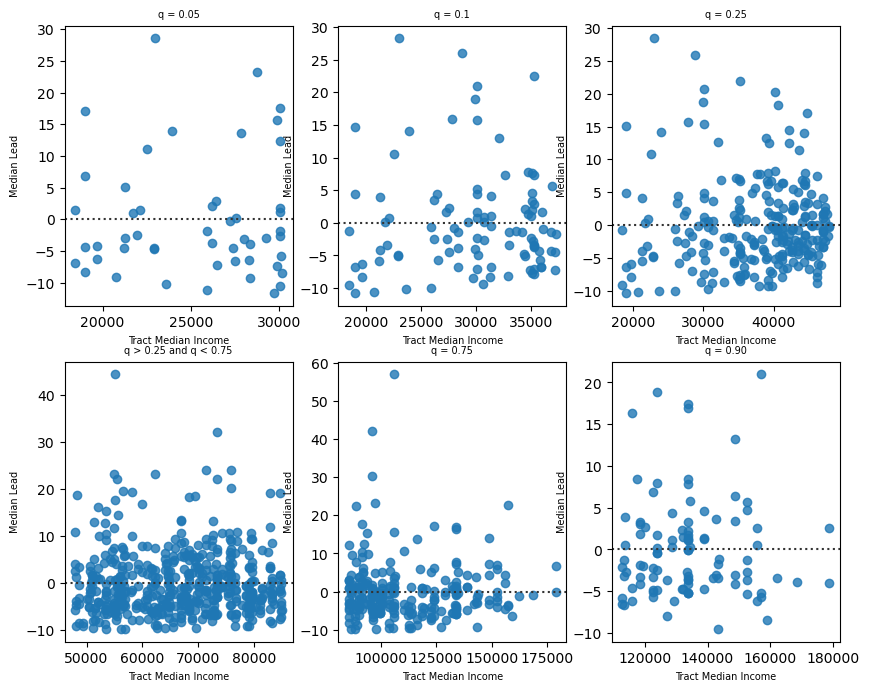

In [56]:
# Fit linear regression model


# Create residual plot
fig, ax = plt.subplots(2,3)
plt.rcParams['figure.figsize'] = 10, 8

for i, ax in zip(range(len(lst_q)), ax.flatten()):

    model = sm.OLS.from_formula("median_lead ~ tract_income", data=lst_q[i]).fit()
    sns.residplot(x="tract_income", y="median_lead", data=lst_q[i], ax=ax)
    ax.set_title(q_names[i], fontsize=7)
    ax.set_xlabel('Tract Median Income', fontsize=7)
    ax.set_ylabel('Median Lead', fontsize=7)
plt.show()

In [34]:
for i in range(len(lst_q)):
    print(q_names[i])
    model = sm.OLS.from_formula("median_lead ~ tract_income", data=lst_q[i]).fit()
    print(model.summary())

q_005
                            OLS Regression Results                            
Dep. Variable:            median_lead   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.487
Date:                Wed, 19 Apr 2023   Prob (F-statistic):              0.229
Time:                        20:31:11   Log-Likelihood:                -181.97
No. Observations:                  50   AIC:                             367.9
Df Residuals:                      48   BIC:                             371.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1963      8.474      0.

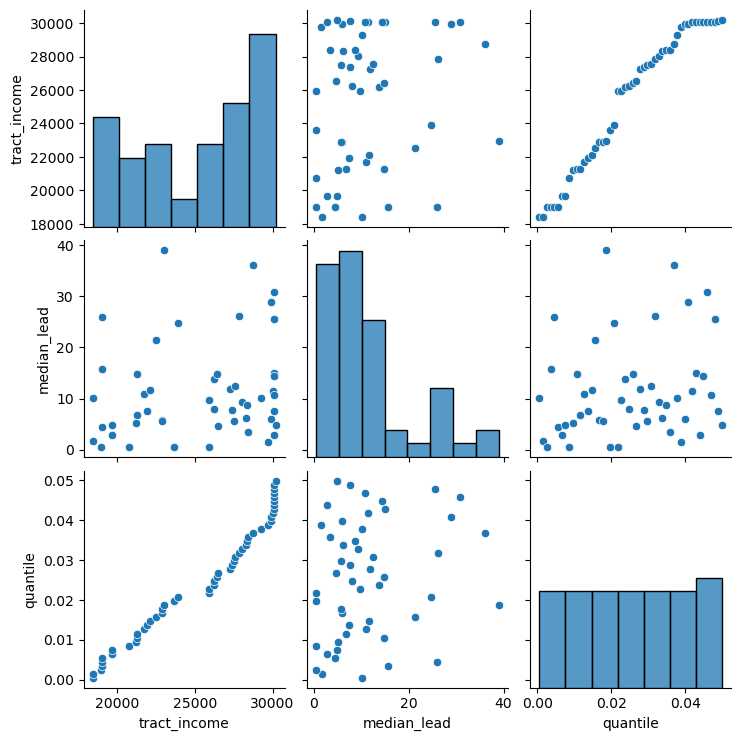

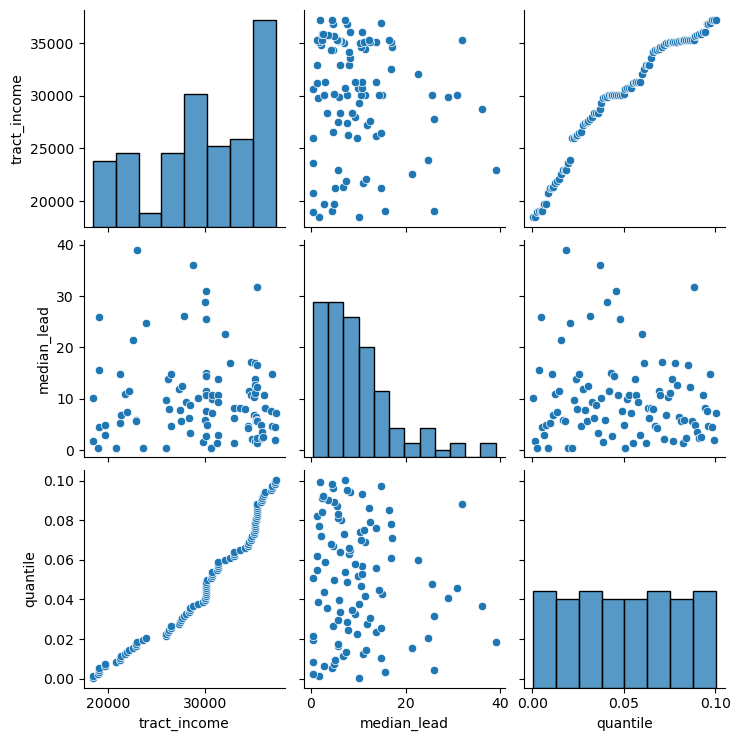

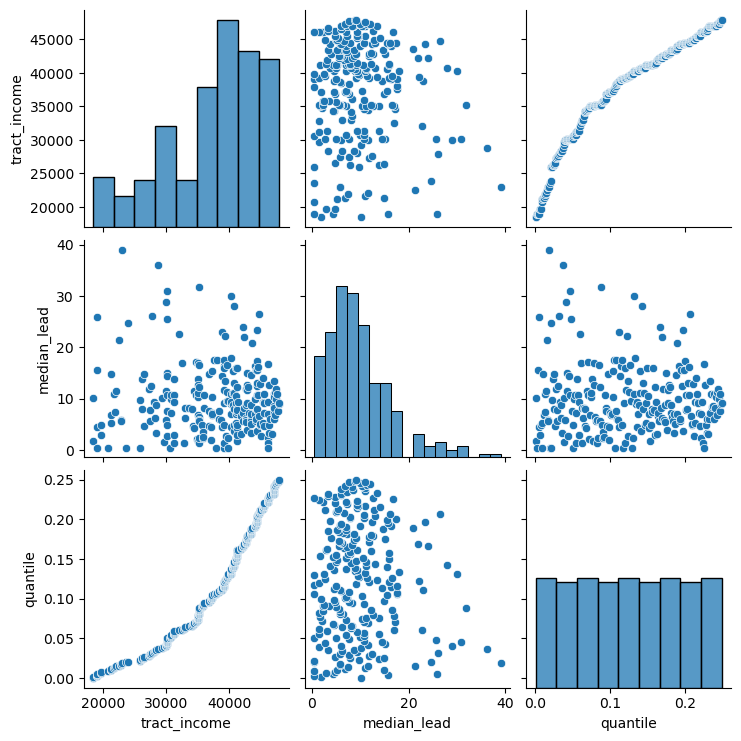

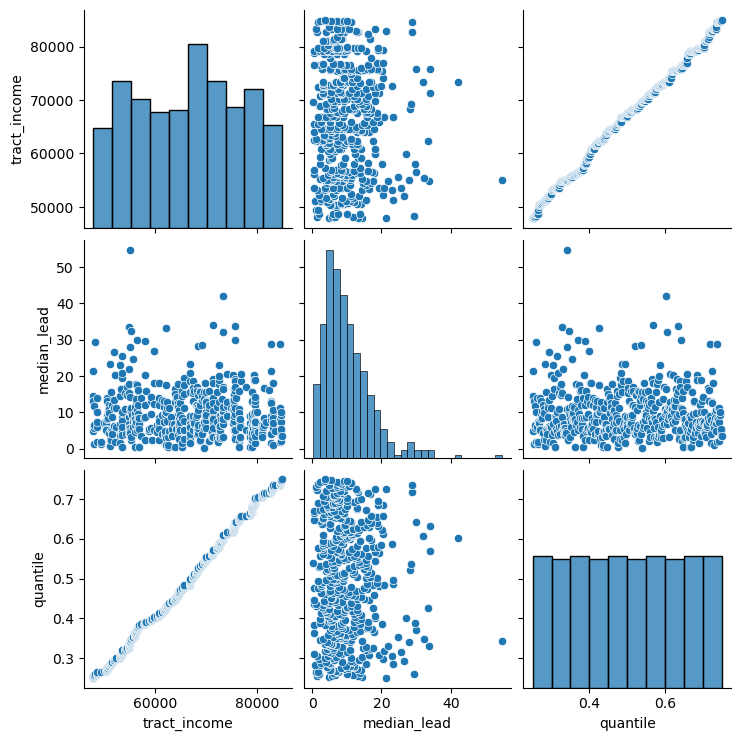

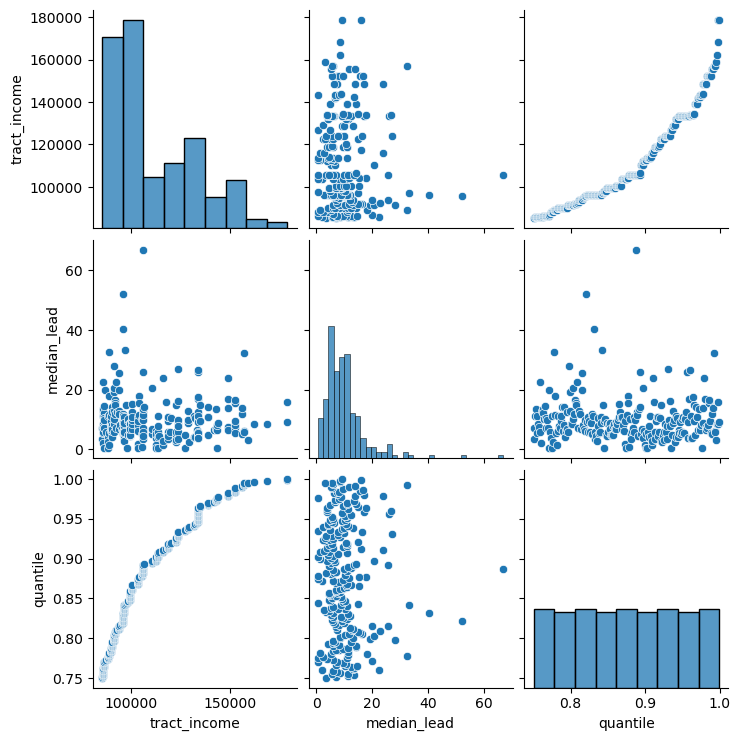

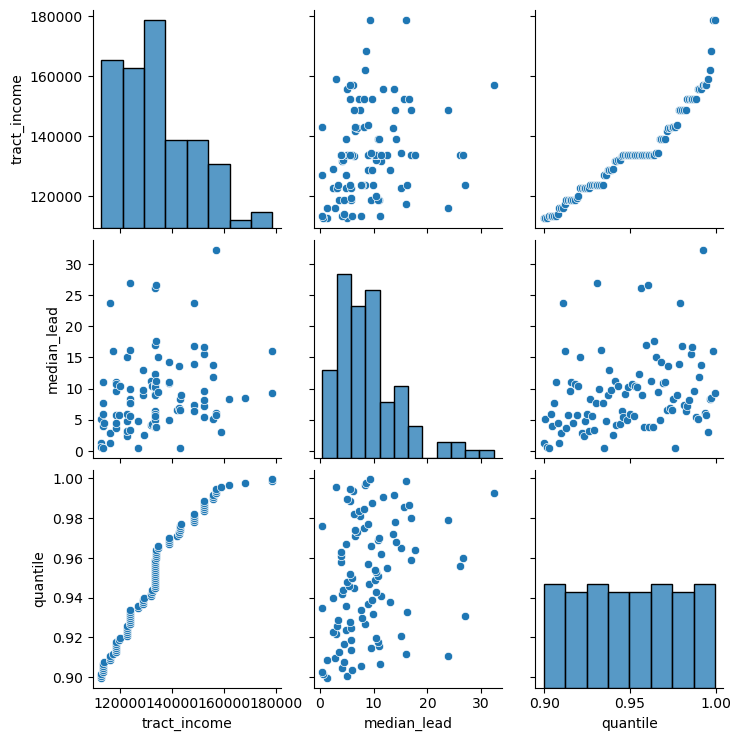

In [35]:
# Create scatter plot matrix


for i in range(len(lst_q)):

    sns.pairplot(lst_q[i])

plt.show()



In [36]:
# Calculate correlations between variables
for i in range(len(lst_q)):
    print(q_names[i])
    corr = lst_q[i].corr()
    print(corr)


q_005
              tract_income  median_lead  quantile
tract_income      1.000000     0.173345  0.981256
median_lead       0.173345     1.000000  0.199685
quantile          0.981256     0.199685  1.000000
q_01
              tract_income  median_lead  quantile
tract_income      1.000000    -0.082563  0.971789
median_lead      -0.082563     1.000000 -0.109453
quantile          0.971789    -0.109453  1.000000
q_025
              tract_income  median_lead  quantile
tract_income      1.000000    -0.060644  0.961456
median_lead      -0.060644     1.000000 -0.065477
quantile          0.961456    -0.065477  1.000000
q_25_75
              tract_income  median_lead  quantile
tract_income      1.000000    -0.039958  0.998340
median_lead      -0.039958     1.000000 -0.037199
quantile          0.998340    -0.037199  1.000000
q_075
              tract_income  median_lead  quantile
tract_income      1.000000    -0.029896  0.955209
median_lead      -0.029896     1.000000 -0.039432
quantile          0

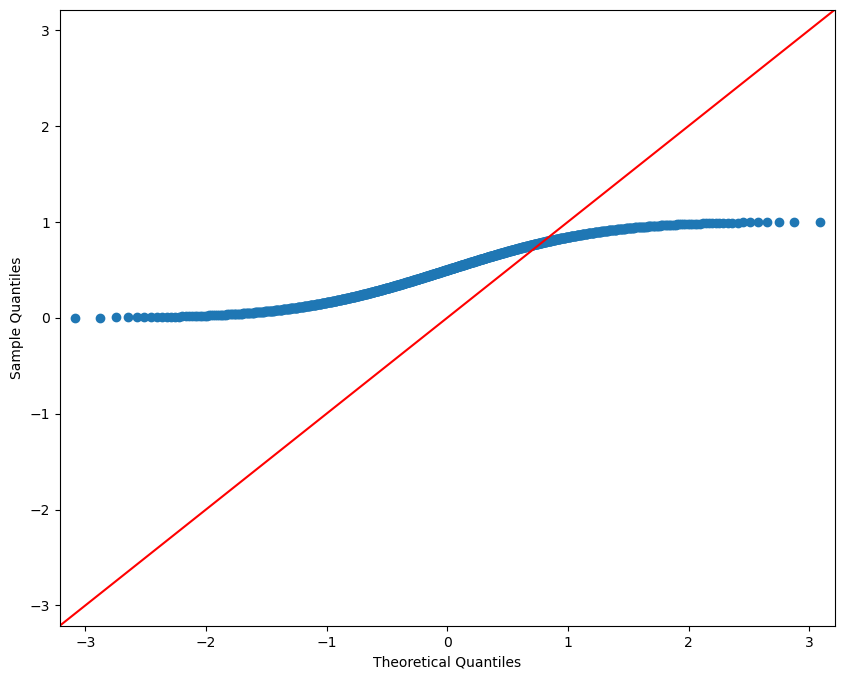

In [37]:
import pylab as py
sm.qqplot(data=df['quantile'], line='45')
py.show()

Indication that this does not follow a normal distribution